## Customer Clustering

### 1. Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import customer_features_monthly as cf
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc

import warnings
warnings.filterwarnings('ignore')

### 2. Read and preprocess customer transaction csv

- Filter for contract issue date (before Jan 2022)
- Drop records with pricing quantity = 0
- Drop records with transaction status 'PARTIALLY CANCELLED'

In [ ]:
# Load in the customer data

cust_df = pd.read_csv('customer_order_flow.csv')
cust_df = cf.customer_preprocess(cust_df)
cust_df = cust_df[cust_df['contract_issue_date'] < '2022-01-01']
filters=(cust_df.pricing_quantity!=0) & (cust_df.contract_line_status!='PARTIALLY CANCELLED')
cust_df=cust_df[filters]



In [3]:
# Output customer id count

cust_ids=cust_df.groupby(['Counter Party Code'])['Counter Party Code'].count().index.tolist()
print('Total Customers:',len(cust_ids))

Total Customers: 2255


### 3. Engineer additional features:
- Currency risk exposure (FX pairs)
- Customer buying behaviour (volume in metric tons, contracts transacted across multiple periods*) 

** Multiple periods are further defined as follows:
- Short term: 0-5+ months
- Mid term: 6-12 months
- Long term: 12+ months

#### 3.1 Define helper functions

**3.1.1 FX Exposure**

In [10]:
# Generate fx tables

def fx_exposure(source, oil, buysell,fxretain_cols):

  df=source.copy()
  df.columns=[x.lower().strip() for x in df.columns]
  filters=(df.commodity_group==oil) & (df.sales_or_purchase==buysell)
  df=df[filters]
  df=df[fxretain_cols]

  filters=(df.fixed_priced_ccy!='X01') & (df.fixed_priced_ccy!='X06') & (df.risk_currency_code!='X01') & (df.risk_currency_code!='X06')
  df=df[filters]

  df['fx_pair']=df['fixed_priced_ccy'] + '-' + df['risk_currency_code']
  df.drop(['fixed_priced_ccy', 'risk_currency_code'],axis=1,inplace=True)

  df=pd.get_dummies(df,columns=['fx_pair'])
  
  ret=['fx_pair_GBP-USD','fx_pair_USD-EUR','fx_pair_USD-GBP','fx_pair_EUR-USD','fx_pair_EUR-EUR',	'fx_pair_USD-USD','fx_pair_GBP-GBP']
  cols={}
  for i in df.columns:
    if i in ret:
      cols[i]='sum'
  
  df=df.groupby(['counter party code']).agg(cols).reset_index()
  df=df.set_index('counter party code')
  df['count']=df.astype(bool).sum(axis=1)

  filters=(df['count']>=1)
  df=df[filters].drop('count',axis=1)

  for i in df.columns:
    df[i]=df[i].map(lambda x: 1 if x>=1 else 0)
  
  return df


source=cust_df.copy()
fxretain_cols=['counter party code','fixed_priced_ccy', 'risk_currency_code']
retain_cols=['counter party code','delivery_period_from','contract_issue_date','lead_time_to_delivery','pricing_quantity']
agg_col_qty='pricing_quantity'
agg_col_contr='lead_time_to_delivery'
custdf_retain=['sales_frequency','unique_products_sold','rapeseed_oil_sales',
       'soybean_oil_sales', 'sunflower_oil_sales', 'palm_oil_sales',
       'coconut_oil_sales', 'palmkernel_oil_sales', 'biodiesel_oil_sales']



**3.1.2 Customer behaviour** 

-  This is done for the  diff commodities future coverage periods previously defined.
-  The variable agg_col = 'pricing_qty' or 'lead_time_to_delivery' to correspond to metric tons (qty) and transaction volume (contracts) respectively.
-  Function can be used flexibly to generate for contract volume transacted and metric tons oil for diff contract periods and diff direction (buy/sell side)

In [6]:
def sum_per(source,oil,buysell,retain_cols,agg_col):

  df=source.copy()
  df.columns=[x.lower().strip() for x in df.columns]

  filters=(df.commodity_group==oil) & (df.sales_or_purchase==buysell)
  df=df[filters]

  df['lead_time_to_delivery'] = (df['delivery_period_from'] - df['contract_issue_date'])/np.timedelta64(1, 'M')
  df=df[retain_cols]

  def define_range(lead_time):
    if lead_time < 0:
      lead_time_range = 'Negative'
    elif lead_time < 3:
      lead_time_range = '< 3 Months'
    elif lead_time < 6:
      lead_time_range = '3-6 Months'
    elif lead_time < 9:
      lead_time_range = '6-9 Months'
    elif lead_time <= 12:
      lead_time_range = '9-12 Months'
    else:
      lead_time_range = '> 12 Months'
    return lead_time_range
  
  df['lead_time_cat'] = df['lead_time_to_delivery'].apply(lambda x: define_range(x))
  df=df.groupby(['counter party code','lead_time_cat'], as_index=False)[agg_col].sum().pivot_table(index = 'counter party code',columns='lead_time_cat', values=agg_col)
  df=pd.DataFrame(df.to_records()).fillna(0)
  df=df.set_index('counter party code')#.drop('Negative',axis=1)
  
  if '< 3 Months' not in df.columns:
    df['< 3 Months']=0
  if '3-6 Months' not in df.columns:
    df['3-6 Months']=0
  if '6-9 Months' not in df.columns:
    df['6-9 Months']=0
  if '9-12 Months' not in df.columns:
    df['9-12 Months']=0
  if '> 12 Months' not in df.columns:
    df['> 12 Months']=0

  df['0-5+ Months']=df['< 3 Months']+df['3-6 Months']
  df['6-12 Months']=df['6-9 Months']+df['9-12 Months']
  df['12+ Months']=df['> 12 Months']


  final_cols=['0-5+ Months','6-12 Months','12+ Months']
  df=df[final_cols]
  
  df['total']=df.sum(axis=1)

  df['%0-5+ Months']=round(100*df['0-5+ Months']/ df['total'],2)
  df['%6-12 Months']=round(100*df['6-12 Months']/ df['total'],2)
  df['%12+ Months']=round(100*df['12+ Months']/ df['total'],2)

  final_cols=['%0-5+ Months','%6-12 Months','%12+ Months','total']
  df=df[final_cols]

  if buysell=='SALES':
    pref_dir='sell_'
  elif buysell=='PURCHASE':
    pref_dir='buy_'
  if agg_col=='pricing_quantity':
    pref_val='qty_'
  elif agg_col=='lead_time_to_delivery':
    pref_val='contr_count_'

  full_pref=pref_dir+pref_val
  df.columns=[full_pref+str(x) for x in df.columns]
  df=df.fillna(0)

  return df

#### 3.2 Combine aggregated customer features and engineered feature above to form cluster dataframe

In [11]:
# Helper functiona

def cluster(source,oil,buysell,retain_cols,agg_col_qty,agg_col_contr,fxretain_cols,custdf_retain):
  
  qty=sum_per(source,oil,buysell,retain_cols,agg_col_qty)
  contracts=sum_per(source,oil,buysell,retain_cols,agg_col_contr)
  fx=fx_exposure(source, oil, buysell,fxretain_cols)
  dfs=[qty,contracts]

  sales_df= pd.concat(dfs,axis=1).fillna(0)
  id_df=sales_df.index.tolist()

  cust_feature_df = cf.cust_features_by_date(cust_df, selected_date = '2022-01-01')
  cust_feature_df.columns=[x.lower().strip() for x in cust_feature_df.columns]
  cust_feature_df=cust_feature_df[cust_feature_df['counter party code'].isin(id_df)].set_index('counter party code')

  cust_feature_df=cust_feature_df[custdf_retain]
  cluster_df=cust_feature_df.join(sales_df)
  cluster_df

  cluster_df=cluster_df.replace([np.inf, -np.inf], 0)

  return cluster_df


In [13]:
# Execute function to generate cluster df for the different oils
source=cust_df.copy()
fxretain_cols=['counter party code','fixed_priced_ccy', 'risk_currency_code']
retain_cols=['counter party code','delivery_period_from','contract_issue_date','lead_time_to_delivery','pricing_quantity']
agg_col_qty='pricing_quantity'
agg_col_contr='lead_time_to_delivery'

custdf_retain=['sales_frequency','unique_products_sold']
oils=['SOYBEAN OIL','RAPE OIL','SUNFLOWER OIL','PALM OIL','COCONUT OIL','PALM KERNEL OIL','BIODIESEL COOKING OIL']
buysell='SALES'

soy=cluster(source,oils[0],buysell,retain_cols,agg_col_qty,agg_col_contr,fxretain_cols,custdf_retain)
rapeseed=cluster(source,oils[1],buysell,retain_cols,agg_col_qty,agg_col_contr,fxretain_cols,custdf_retain)
sunflower=cluster(source,oils[2],buysell,retain_cols,agg_col_qty,agg_col_contr,fxretain_cols,custdf_retain)
palm=cluster(source,oils[3],buysell,retain_cols,agg_col_qty,agg_col_contr,fxretain_cols,custdf_retain)
coconut=cluster(source,oils[4],buysell,retain_cols,agg_col_qty,agg_col_contr,fxretain_cols,custdf_retain)
palmk=cluster(source,oils[5],buysell,retain_cols,agg_col_qty,agg_col_contr,fxretain_cols,custdf_retain)
bio=cluster(source,oils[6],buysell,retain_cols,agg_col_qty,agg_col_contr,fxretain_cols,custdf_retain)

### 4. Run clustering 

- Reduce dimensionality through PCA, setting n_components to dynamically account for the 98% variance per oil
- Use elbow method and distortion metric to calculate for optimal k and verify quality using silhouette score
- Understand dominant features in the cluster 

This will generate multiple files:

- oil.csv -> clustered customer per oil
- oil_fimport.csv -> feature contribution to cluster per oil

**4.1 Initial Clustering**

In [ ]:
# Initialize containers
loop_df=[soy,rapeseed,sunflower,palm,coconut,palmk]
df_label=['soy','rapeseed','sunflower','palm','coconut','palmk']
k_vals=[7,10,15,13,5,6]
silscores=[]

ctr=0
for i in loop_df:
  df=i
  scaled_df=StandardScaler().fit_transform(df)
  scaled_df=pd.DataFrame(scaled_df,columns=df.columns).join(pd.DataFrame({'counter party code':df.index.tolist()})).set_index('counter party code')

  ## Determine how many components are needed to explain 95% of the variation
  pca = PCA(.98)
  pca.fit_transform(scaled_df)
  n_components=pca.n_components_

  ## Initiate PCA instance
  pca=PCA(n_components=n_components)
  cluster_df=pca.fit_transform(scaled_df)

  # Instantiate the clustering model and visualizer
  model = KMeans()
  visualizer = KElbowVisualizer(
      model, k=(2,int(round(scaled_df.shape[0]*0.05,0))), metric='distortion', timings=False, random_state=1988)
  wcss = []
  for i in range(2,int(round(scaled_df.shape[0]*0.05,0))):
    model = KMeans(n_clusters = i, init = "k-means++")
    model.fit(cluster_df)
    wcss.append(model.inertia_)

  print(df_label[ctr].upper())
  visualizer.fit(cluster_df)        
  visualizer.show()
  plt.show()       

  ## Run k-means and save results
  index_max = k_vals[ctr]
  kmeans = KMeans(n_clusters=index_max, random_state=1988)
  labels = kmeans.fit_predict(cluster_df)
  silhouette_avg = silhouette_score(cluster_df, labels)
  silscores.append(silhouette_avg)
  print('Silhouette score for optimal k',silhouette_avg,'\n')

  df.join(pd.DataFrame({'counter party code':df.index.to_list(),'cluster':labels}).set_index('counter party code')).to_csv(df_label[ctr]+'.csv')

  ## Derive feature contribution
  fimport=pd.DataFrame(abs(pca.components_))
  fimport['PC#']=fimport.index+1
  fimport=fimport.set_index('PC#')
  fimport.columns=df.columns
  fimport['total']=fimport.sum(axis=1)

  ### Explained variance df

  expvar=pd.DataFrame({'variance':pca.explained_variance_ratio_})
  expvar['PC#']=expvar.index+1
  expvar=expvar.set_index('PC#')

  ### Join the 2 tables
  fimport=fimport.join(expvar)

  ### Compute cell contribution to total var explained
  for col in df.columns:
    fimport[col]=100*fimport['variance']*(fimport[col]/fimport['total'])
  fimport[df.columns].sum(axis=0).sort_values(ascending=False).to_csv(df_label[ctr]+'_fimport.csv',header=None)
  ctr+=1


**4.2 Optional: Secondary Grouping**

In the event, the clusters need to be further collapsed, a dendogram showing the cluster centers are plotted. Use this as aid but verify business sense by checking against customer information

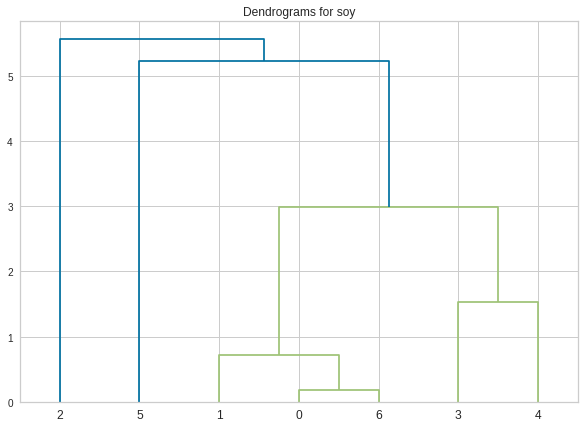

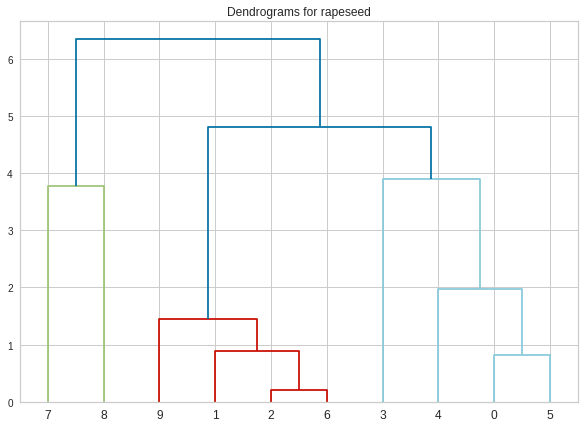

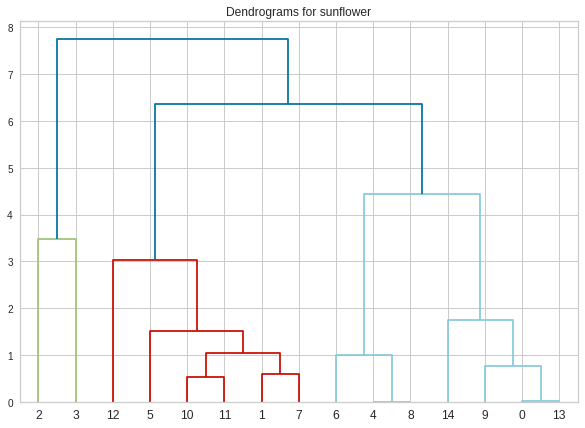

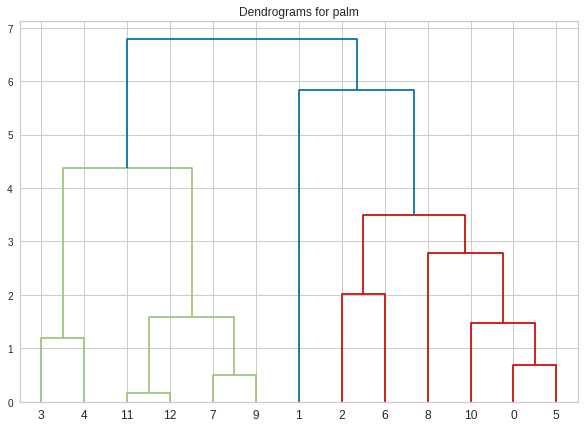

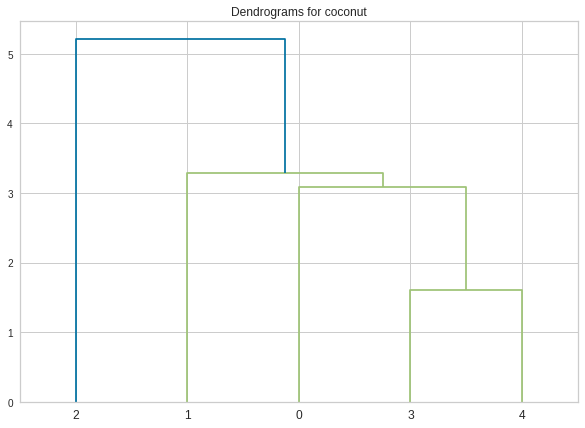

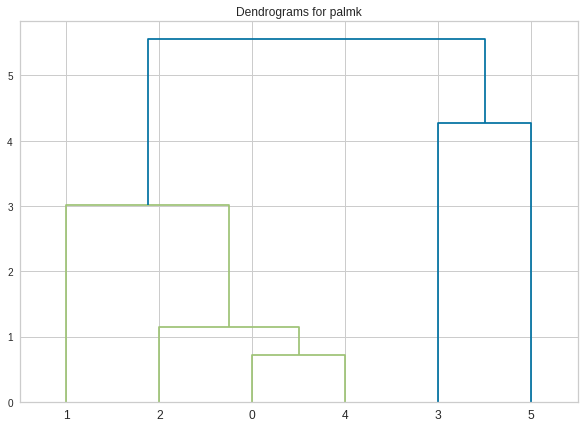

In [16]:
oil=['soy.csv','rapeseed.csv','sunflower.csv','palm.csv','coconut.csv','palmk.csv']
features=['soy_fimport.csv','rapeseed_fimport.csv','sunflower_fimport.csv','palm_fimport.csv','coconut_fimport.csv','palmk_fimport.csv']

ctr=0
for i in oil:

  df=pd.read_csv(i)
  df_group=df.copy()

  fimport=pd.read_csv(features[ctr],header=None)
  fimport.columns=['features','contr']
  cols=['cluster']+fimport.features[0:5].tolist()

  df_group=df_group[cols]
  df_group=df_group.groupby(['cluster']).agg(np.mean).reset_index()
  df_group=df_group.set_index('cluster')
  df_group=df_group.join(pd.DataFrame(df.groupby(['cluster'])['counter party code'].count()))
  df_group.rename(columns = {'counter party code':'count'}, inplace = True)
  df_group.to_csv(i.split('.')[0]+'_top5f_.csv')

  ctr+=1

  df=df_group.drop('count',axis=1)
  scaled_df=StandardScaler().fit_transform(df)
  scaled_df=pd.DataFrame(scaled_df,columns=df.columns).join(pd.DataFrame({'cluster':df.index.tolist()})).set_index('cluster')

  plt.figure(figsize=(10, 7))  
  plt.title('Dendrograms for '+ i.split('.')[0])  
  dend = shc.dendrogram(shc.linkage(scaled_df, method='ward'))
  plt.show()
  print('\n')

**4.3 Rerun clustering exercise in 4.1 with the below changes:**
- Include averaged monthly transaction qty per customer
- Exclude some features: (a) sell_contract_counts across different periods, (b) unique oils dealt

**4.3.1 Derive averaged monthly transaction qty per customer**

In [17]:
cust_df = pd.read_csv('customer_order_flow.csv')
cust_df = cf.customer_preprocess(cust_df)
cust_df = cust_df[cust_df['contract_issue_date'] < '2022-01-01']
filters=(cust_df.pricing_quantity!=0) & (cust_df.contract_line_status!='PARTIALLY CANCELLED')
cust_df=cust_df[filters]

oil_csv=['soy.csv','rapeseed.csv','sunflower.csv','palm.csv','coconut.csv','palmk.csv']
oils_label=['SOYBEAN OIL','RAPE OIL','SUNFLOWER OIL','PALM OIL','COCONUT OIL','PALM KERNEL OIL','BIODIESEL COOKING OIL']

ctr=0
for i in oil_csv:

  cluster_file=i
  oil_label=oils_label[ctr]

  df=pd.read_csv(cluster_file)
  id_list=df['counter party code'].tolist()

  monthly_qty=[]
  for id in id_list:
    monthly_qty.append(cf.cust_monthly_matrix(cust_df, id, selected_commodity = oil_label))

  monthly_qty_df=pd.concat(monthly_qty, ignore_index=True)
  monthly_qty_df=monthly_qty_df[['counter_party_code','sales_quantity_on_month']]
  monthly_qty_df.columns=['counter party code', 'monthlyqty']
  monthly_qty_df=monthly_qty_df.set_index('counter party code')
  monthly_qty_df=pd.DataFrame(monthly_qty_df.groupby('counter party code')['monthlyqty'].mean())

  df=df.set_index('counter party code')
  df.join(monthly_qty_df).to_csv(cluster_file.split('.')[0] + '_final.csv')

  ctr+=1

**4.3.2 Rerun k means exercise tuning k and n_components**

This will again generate 2 files per oil:
- oil2.csv -> clustered customers
- oil_fimport2.csv-> feature contribution to cluster per oil

SOY


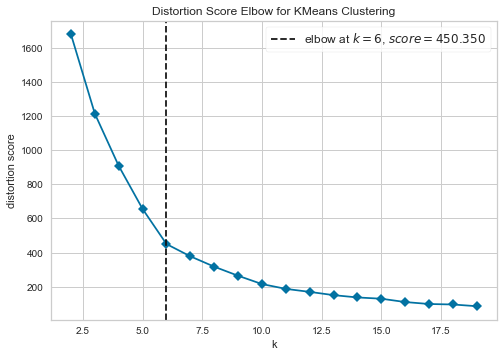

Silhouette score for optimal k 0.6493340943466057 

RAPESEED


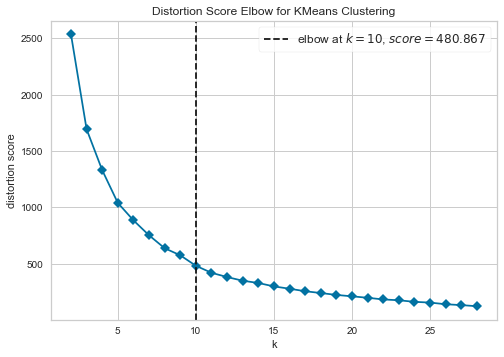

Silhouette score for optimal k 0.5392930059550707 

SUNFLOWER


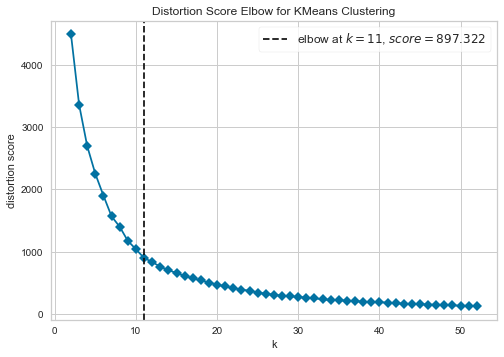

Silhouette score for optimal k 0.6691079714167306 

PALM


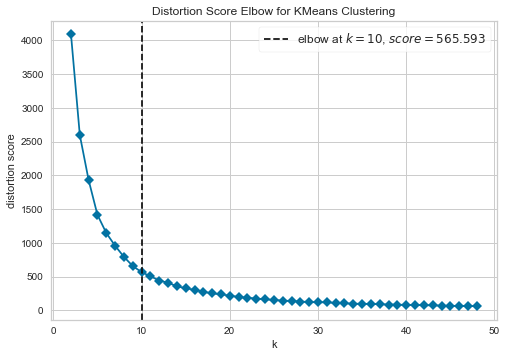

Silhouette score for optimal k 0.6842636424921047 

COCONUT


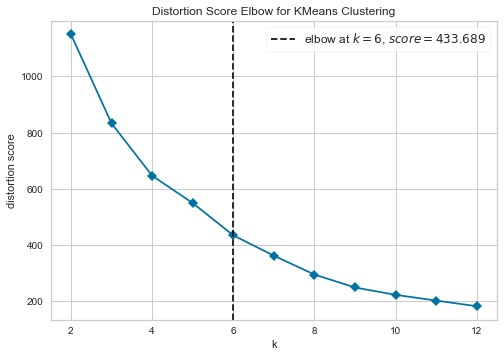

Silhouette score for optimal k 0.4483889614967023 

PALMK


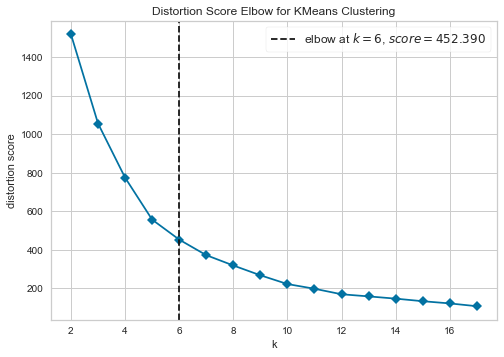

Silhouette score for optimal k 0.7231723913146619 



In [15]:
# Run kmeans (Metric for k optmization: DISTORTION)
loop_df=[soy,rapeseed,sunflower,palm,coconut,palmk]
df_label=['soy','rapeseed','sunflower','palm','coconut','palmk']
oil_csv=['soy_final.csv','rapeseed_final.csv','sunflower_final.csv','palm_final.csv','coconut_final.csv','palmk_final.csv']
k_vals=[7,8,10,10,5,6]
silscores=[]

ctr=0
for i in loop_df:
    df=pd.read_csv(oil_csv[ctr]).drop('cluster',axis=1).set_index('counter party code')
    
    drop_cols = [v for v in soy.columns if 'sell_contr_count' in v] + ['unique_products_sold']
    df = df.drop(drop_cols, axis = 1)
    

    scaled_df=StandardScaler().fit_transform(df)
    scaled_df=pd.DataFrame(scaled_df,columns=df.columns).join(pd.DataFrame({'counter party code':df.index.tolist()})).set_index('counter party code')

    ## Determine how many components are needed to explain 95% of the variation
    pca = PCA(.98)
    pca.fit_transform(scaled_df)
    n_components=pca.n_components_

    ## Initiate PCA instance
    pca=PCA(n_components=n_components)
    cluster_df=pca.fit_transform(scaled_df)

    # Instantiate the clustering model and visualizer
    model = KMeans()
    visualizer = KElbowVisualizer(
      model, k=(2,int(round(scaled_df.shape[0]*0.05,0))), metric='distortion', timings=False, random_state=1988)
    wcss = []
    for i in range(2,int(round(scaled_df.shape[0]*0.05,0))):
        model = KMeans(n_clusters = i, init = "k-means++")
        model.fit(cluster_df)
        wcss.append(model.inertia_)

    print(df_label[ctr].upper())
    visualizer.fit(cluster_df)        
    visualizer.show()
    plt.show()       

    ## Run k-means and save results
    index_max = k_vals[ctr]
    kmeans = KMeans(n_clusters=index_max, random_state=1988)
    labels = kmeans.fit_predict(cluster_df)
    silhouette_avg = silhouette_score(cluster_df, labels)
    silscores.append(silhouette_avg)
    print('Silhouette score for optimal k',silhouette_avg,'\n')

    df.join(pd.DataFrame({'counter party code':df.index.to_list(),'cluster':labels}).set_index('counter party code')).to_csv(df_label[ctr]+'2.csv')


    ## Derive feature importance
    fimport=pd.DataFrame(abs(pca.components_))
    fimport['PC#']=fimport.index+1
    fimport=fimport.set_index('PC#')
    fimport.columns=df.columns
    fimport['total']=fimport.sum(axis=1)

    ### Explained variance df

    expvar=pd.DataFrame({'variance':pca.explained_variance_ratio_})
    expvar['PC#']=expvar.index+1
    expvar=expvar.set_index('PC#')

    ### Join the 2 tables
    fimport=fimport.join(expvar)

    ### Compute cell contribution to total var explained
    for col in df.columns:
        fimport[col]=100*fimport['variance']*(fimport[col]/fimport['total'])
    fimport[df.columns].sum(axis=0).sort_values(ascending=False).to_csv(df_label[ctr]+'_fimport2.csv',header=None)
    ctr+=1
